# Fundamentals of Social Data Science
# Week 4 Day 2. Network Analysis 

In this lab I demonstrate three different approaches to creating networks of users from subreddits. These can be used in order to represent user interaction data as a network. Each network will represent the data in slightly different way and can be considered as such. Interestingly, these are all created from the same table of comments. 

We first create our list of posts as before. But this time around we then go to each story and collect the comments. Please note that this is not a full set of comments for any given story but the comments that Reddit would show when you go to that page. That is, it does not include comments buried under 'more comments'. But with a list of comments we can create these networks below: 

1. **Threaded networks**. `create_comment_tree`: Each post will be a single meta-thread. That is it is really a series of threads but if we say root=True then it will create a node for the post and then connect all the nodes to that post. We can look to metrics like 'geodesic' in networks to collect the deepest or widest thread and compare across posts. 
2. **User-interaction networks**. `create_user_interaction_network(comments_df)`: While we have posts, these have authors. So an author can reply to someone more than once or people can reply to each other. So if we build a network around who replies to whom rather than which post replies to which post, we no longer have a tree structure. But do we have a dense core? Do we have many different components or one big component (i.e. everyone replying to everyone else).
3. **Bipartite networks**. `create_user_post_network(comments_df)`: We can explore which users share a sub in common or which subs share users in common. These can be seen as a bipartite (i.e. two separate side ) network. In social network analysis is this often also called a two-mode network. 

Today, you're encouraged to play with the parameters below. What if we download more posts? Do you find that the user-interaction network is very clustered or a big hairball of replies? These structures help build intuition though they may or may not be easy to directly integrate in any analysis of your topic. Nonetheless, I hope that networks helps you think about how to appreciate data at scale and potentially provides a new framework for approaching relations between people, social structure, and social data science questions more broadly.

You are welcome to tweak the code as you see fit. This lab is much like the earlier t-SNE lab in that you are encouraged to explore and see what patterns seem coherent to you. Confirmatory statistics with networks are very tricky but descriptive statistics and inductive insights are readily available. 

Note that the `get_post_comments` does not have a caching function. You may consider caching or other ways to store the user data rather than redownloading it. Also, consider that because we are trying to leave a light footprint on Reddit, this code sleeps for 2 second between requests. Finally, notice that now we have a more general RedditScraper. The only real difference is that we have a "sort" parameter so you can sort by 'top' or 'new'. 

These exercises are optional but should guide your consideration. 

**Exercise 1**. Visualize the comment structore of 5 top stories from a subreddit of choice. 

**Exercise 2**. Create a Jaccard similarity score for three posts based on their overlap in users in the comments. 

**Exercise 3**. How might you create a plot where the nodes are sized differently depending on centrality? Why can't we just take raw scores for the size (hint, it will make nodes very tiny).

**Exercise 4**. Consider why cosine similarity might make sense. In this case, try Eucliean and Jaccard as well to consider their own respective logic. Euclidean will likely find users who are positionally central where cosine should find users who are positionally similar. 

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import pandas as pd
from models.reddit_scraper import RedditScraper
from config.settings import USER_AGENT
from matplotlib import pyplot as plt
import networkx as nx
from utils.network_builder import *
import time


In [5]:
# 1. Get the top 3 posts from a subreddit
subreddit_name = "wallstreetbets"
scraper = RedditScraper(USER_AGENT)
posts = scraper.get_subreddit_posts(subreddit_name, limit=5, cache=False, sort="top")
posts_df = pd.DataFrame(posts)
display(posts_df)

# 2. Get the comments of the posts
comment_list = []

for post in posts:
    comments = scraper.get_post_comments(post['id'])
    comment_list.append(pd.DataFrame(comments))
    time.sleep(2)

comments_df = pd.concat(comment_list)



Fetching posts from https://api.reddit.com/r/wallstreetbets/top
Response keys: dict_keys(['kind', 'data'])


,id,title,selftext,author,score,created_utc,num_comments,url
0,1h8a2ua,"Congrats guys, $PLTR now trades at 420x traili...",,betsharks0,2313,1.733515e+09,400,https://i.redd.it/fenm906c9a5e1.png
1,1h8agfw,Which one of you regards writes for Forbes?,,sa-sa-sa-soma,2200,1.733516e+09,157,https://i.redd.it/m11na238ca5e1.jpeg
2,1h8je0t,420k gains in last 3 months,Lots of nvidia option plays in October. Took a...,uchihaItachi01,1277,1.733542e+09,124,https://www.reddit.com/gallery/1h8je0t
3,1h8uwp4,"Fired my old fart financial advisor, stopped s...","I’m no expert by any means, I’ve just been lis...",ProfessorAkaliOnYT,1365,1.733586e+09,249,https://www.reddit.com/gallery/1h8uwp4
4,1h8s4h5,Hitler bends the knee to BTC &amp; MSTR (oc),,Ok-Put8247,757,1.733577e+09,123,https://v.redd.it/czfcdljnue5e1


Fetching comments from https://api.reddit.com/comments/1h8a2ua
Fetching comments from https://api.reddit.com/comments/1h8agfw
Fetching comments from https://api.reddit.com/comments/1h8je0t
Fetching comments from https://api.reddit.com/comments/1h8uwp4
Fetching comments from https://api.reddit.com/comments/1h8s4h5


In [7]:
comments_df

,comment_id,parent_id,post_id,author,body
0,m0raovq,None,1h8a2ua,VisualMod,\n**User Report**| | | |\n:--|:--|:--|:--\n**T...
1,m0rcwxe,None,1h8a2ua,makshelah,Imagine the pain of being short PLTR for the l...
2,m0rdkrj,m0rcwxe,1h8a2ua,jfwelll,I may be early but im not wrong. \n\nDr. Micha...
3,m0ri3wl,m0rdkrj,1h8a2ua,Appropriate_Ice_7507,It’s the same thing Michael. It’s the same th...
4,m0ro80e,m0ri3wl,1h8a2ua,mouthful_quest,I’m Jacked! JaCKed to tHe TITs!
...,...,...,...,...,...
115,m0vref3,None,1h8s4h5,TabletopParlourPalm,"Mate, you can't pull this meme without incorpo..."
116,m0w0g50,None,1h8s4h5,spac420,so many weak ass keys out there. just need a f...
117,m0wb8r1,m0w0g50,1h8s4h5,Ok-Put8247,Post your short positions or GTFO
118,m0v7pmy,None,1h8s4h5,pornAnalyzer_,Assad right now.


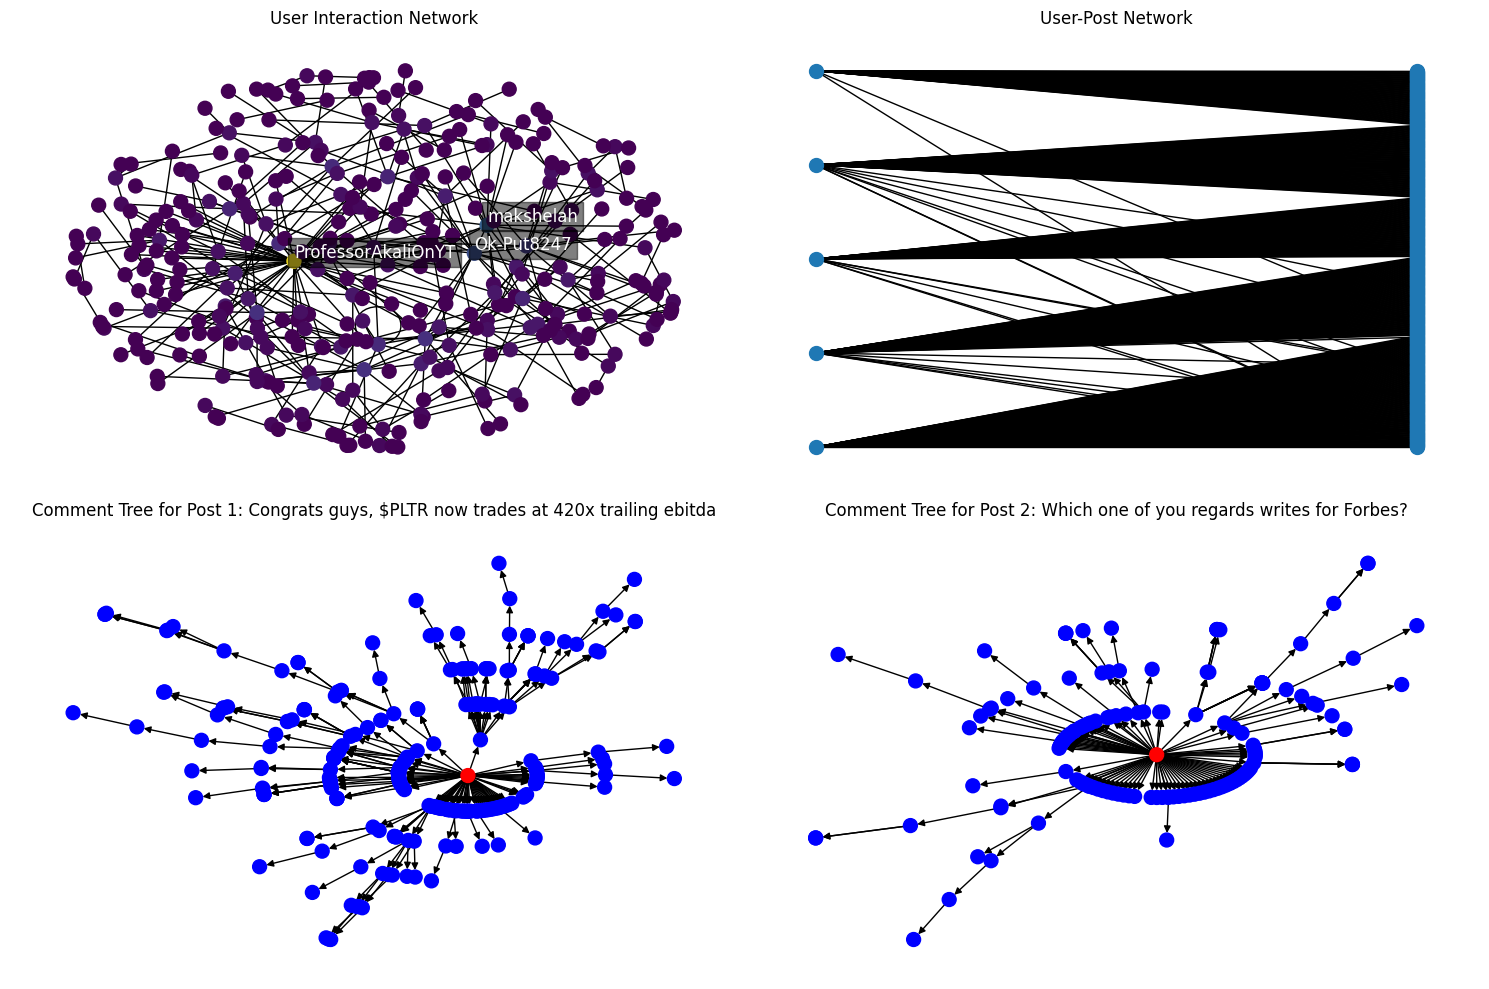

In [16]:
# Visualization example
plt.figure(figsize=(15, 10))

# User network
plt.subplot(221)

user_network = create_user_interaction_network(comments_df)
pos_users = nx.spring_layout(user_network, k=1, iterations=200)

degree_centrality = nx.degree_centrality(user_network)
node_color = [degree_centrality[node] for node in user_network.nodes()]
nx.draw(user_network, pos_users, node_size=100, node_color=node_color, cmap=plt.cm.viridis)

# Label the top 3 nodes by in-degree centrality
top_3_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:3]

labels = {node: node for node in top_3_nodes}
nx.draw_networkx_labels(user_network, pos_users, labels=labels, font_color='white', bbox=dict(facecolor='black', alpha=0.5), verticalalignment='bottom', horizontalalignment='left')
plt.title("User Interaction Network")

# Bipartite network
plt.subplot(222)

bipartite_network = create_user_post_network(comments_df)
pos_bipartite = nx.bipartite_layout(bipartite_network, 
                                   nodes=[n for n, d in bipartite_network.nodes(data=True) 
                                        if d['bipartite']==0])
nx.draw(bipartite_network, pos_bipartite, node_size=100)
plt.title("User-Post Network")

# Comment tree for post 1
plt.subplot(223)
post_1_comments = comments_df[comments_df['post_id'] == posts[0]['id']]
comment_tree_1 = create_comment_tree(post_1_comments, include_root=True)
pos_tree_1 = nx.kamada_kawai_layout(comment_tree_1)
nx.draw(comment_tree_1, pos_tree_1, node_size=100, 
        node_color=['red' if d['type']=='post' else 'blue' 
                   for _, d in comment_tree_1.nodes(data=True)])
plt.title(f"Comment Tree for Post 1: {posts[0]['title']}")

# Comment tree for post 2
plt.subplot(224)
post_2_comments = comments_df[comments_df['post_id'] == posts[1]['id']]
comment_tree_2 = create_comment_tree(post_2_comments, include_root=True)
pos_tree_2 = nx.kamada_kawai_layout(comment_tree_2)
nx.draw(comment_tree_2, pos_tree_2, node_size=100, 
        node_color=['red' if d['type']=='post' else 'blue' 
                   for _, d in comment_tree_2.nodes(data=True)])
plt.title(f"Comment Tree for Post 2: {posts[1]['title']}")

plt.tight_layout()
plt.show()



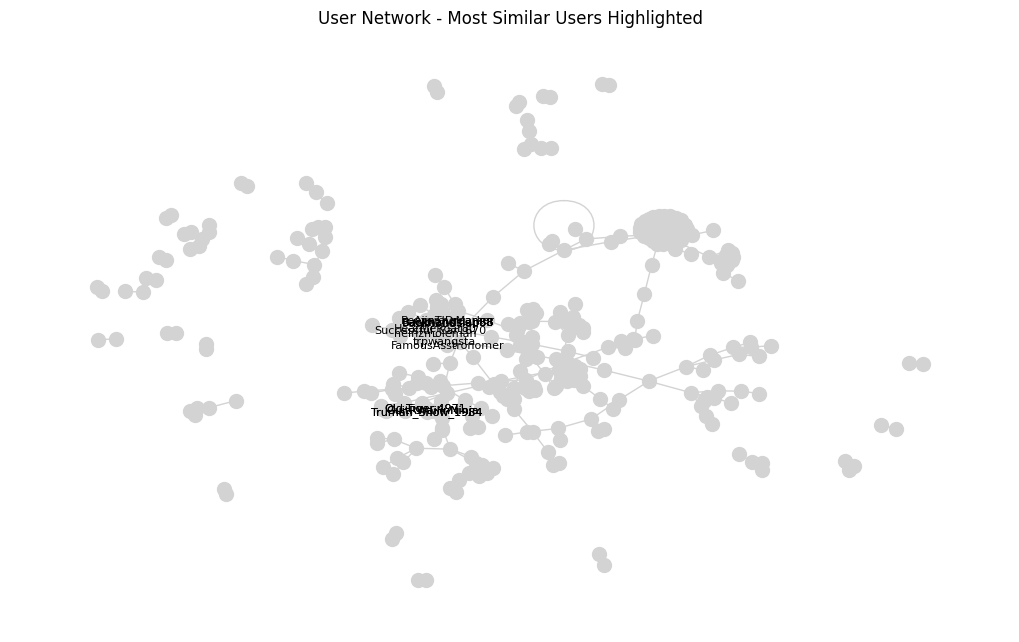

Truman_Show_1984 - GuitRWailinNinja: 1.000
Truman_Show_1984 - Old-Tiger-4971: 1.000
GuitRWailinNinja - Old-Tiger-4971: 1.000
trpwangsta - FamousAsstronomer: 1.000
Backhandslap88 - HearMeRoar80: 1.000
Backhandslap88 - bdh2067: 1.000
Backhandslap88 - AzureDreamer: 1.000
Backhandslap88 - Successful_Car1670: 1.000
Backhandslap88 - heinzmoleman: 1.000
Backhandslap88 - BonjinTheMark: 1.000


In [9]:
similar_users = find_similar_users(user_network, metric='cosine')
# similar_users = find_similar_users(user_network, metric='jaccard')
# similar_users = find_similar_users(user_network, metric='euclidean')

# Visualize similar pairs
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(user_network)

# Draw full network in gray
nx.draw(user_network, pos, node_color='lightgray', 
        edge_color='lightgray', width=1, node_size=100)

# Highlight similar pairs
for user1, user2, sim in similar_users[:10]:
    # Draw edge in red with width proportional to similarity
    nx.draw_networkx_edges(user_network, pos, 
                          edgelist=[(user1, user2)],
                          edge_color='red',
                          width=sim*3)
    
    # Label nodes
    nx.draw_networkx_labels(user_network, pos, 
                           labels={user1: user1, user2: user2},
                           font_size=8)

plt.title("User Network - Most Similar Users Highlighted")
plt.show()

# Print similarities
for user1, user2, sim in similar_users[:10]:
    print(f"{user1} - {user2}: {sim:.3f}")

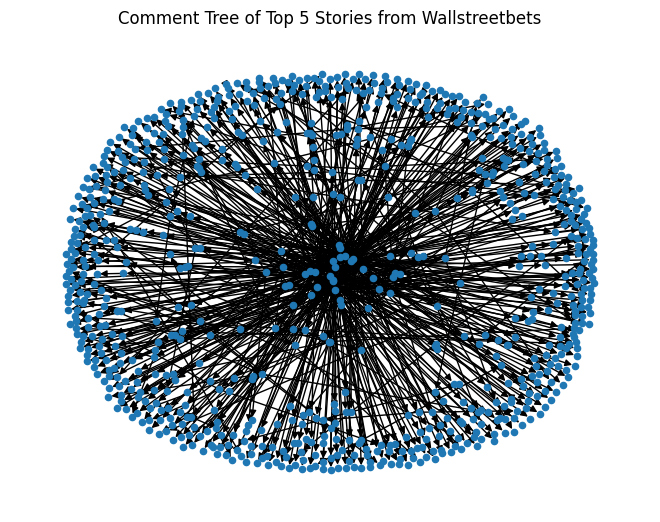

In [ ]:
# Exercise 1

import networkx as nx
import matplotlib.pyplot as plt

G1 = create_comment_tree(comments_df, include_root=True)
# Visualize thhjhkhjhjkhkjhcsacas=False, node_size=20, font_size=8)
plt.title("Comment Tree of Top 5 Stories from Wallstreetbets")
plt.show()


In [49]:
# Exercise 2
def jaccard_similarity(set1, set2):
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    return len(intersection) / len(union)

posts = comments_df['post_id'].unique()
grouped_comments = comments_df[['author', 'post_id']].groupby('post_id').agg({'author': set})
# # Example: For 3 posts, find the users in the comments
users_post1 = grouped_comments.loc[posts[0], 'author']
users_post2 =grouped_comments.loc[posts[1], 'author']
users_post3 = grouped_comments.loc[posts[2], 'author']

# Calculate Jaccard similarity
sim_1_2 = jaccard_similarity(users_post1, users_post2)
sim_1_3 = jaccard_similarity(users_post1, users_post3)
sim_2_3 = jaccard_similarity(users_post2, users_post3)

print(f"Jaccard similarity between post 1 and 2: {sim_1_2}")
print(f"Jaccard similarity between post 1 and 3: {sim_1_3}")
print(f"Jaccard similarity between post 2 and 3: {sim_2_3}")



Jaccard similarity between post 1 and 2: 0.03237410071942446
Jaccard similarity between post 1 and 3: 0.024
Jaccard similarity between post 2 and 3: 0.014150943396226415


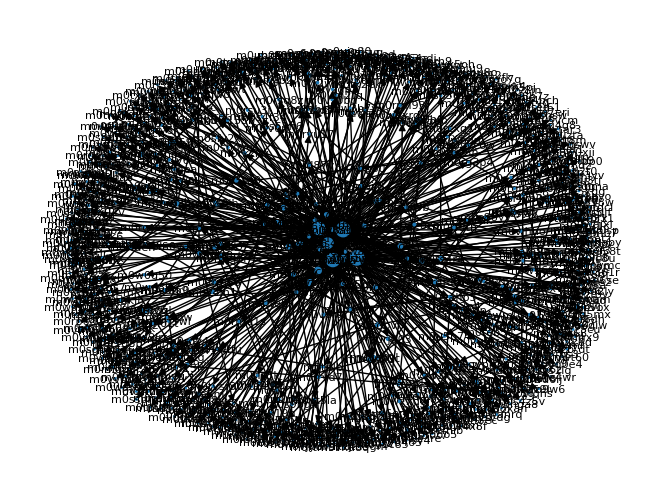

In [53]:
# Exercise 3

centrality = nx.degree_centrality(G1)  # Dictionary with nodes as keys and centrality values as values

# Visualize the graph with node sizes proportional to their centrality
node_sizes = [1000 * centrality[node] for node in G1.nodes()]
nx.draw(G1, with_labels=True, node_size=node_sizes, font_size=8)
plt.show()


Raw centrality scores can vary widely, causing some nodes to have excessively large sizes and others to be very tiny. This would make a visualization hard to interpret. It’s better to normalize or scale the sizes to make them more readable.


Goal: Compare these similarity measures and consider why each might make sense for this task.

Cosine Similarity:

Measures the cosine of the angle between two vectors. It’s often used for measuring how similar two documents (or users) are, based on the direction of their vector, regardless of their magnitude.
In this case, you could represent each user as a vector of posts they have commented on and then compute similarity.
Example (cosine similarity between two vectors):

python
Copy code
from sklearn.metrics.pairwise import cosine_similarity

# Create vectors (e.g., binary vectors of presence/absence of comments)
vector1 = [1, 0, 1, 0, 1]  # User 1's comment vector
vector2 = [0, 1, 1, 1, 0]  # User 2's comment vector

similarity = cosine_similarity([vector1], [vector2])
print(f"Cosine similarity: {similarity[0][0]}")
Euclidean Distance:

Measures the straight-line distance between two points in the space. It’s sensitive to the magnitude of differences.
Jaccard Similarity:

Measures the proportion of shared elements between two sets, useful when comparing sets like users who commented on posts.